# Principal components analysis for order parameter construction

In [43]:
from analysis_tools.read_gsd import ReadGSD
from analysis_tools.feature_creation import FrameToFeatures, TrajectoryToFeatures
from analysis_tools.feature_creation import FramesToFeaturesComposition, TrajectoryToFeaturesComposition

---

## Models

In [ ]:
from numpy import array, arange

### Model data

#### Hard disks

In [114]:
N_nn = 5000 #number of nearest nighbors for pca analysis
split = 2 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 100 #skip this many particles in generating features
nn_inc = 10 #reduces the number of nearest neighbors to include as features
method = ['distance']

In [124]:
#specify what data to read in and process
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p'), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer')]

#### Widom-Rowlinson

In [98]:
N_nn = 5000 #number of nearest nighbors for pca analysis
split = 2 #chunks the data up so it can be processed by the pca tool if really large
particle_inc = 100 #skip this many particles in generating features
nn_inc = 10 #reduces the number of nearest neighbors to include as features
method = ['distance']

In [99]:
#specify what data to read in and process
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]

### Density range

In [ ]:
etas = []
[etas.extend(etas_) for etas_, _ in file_data]
etas = array(etas)

---

## Perfom PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

### Train on ideal gas structure first to identify trivial variance contributions

In [ ]:
randomize = True
incpca_ig = IncrementalPCA(n_components=50, whiten=False)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            incpca_ig.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.55

1
2
eta=0.555

1
2
eta=0.56

1
2
eta=0.565

1
2
eta=0.57

1
2
eta=0.575

1
2
eta=0.58

1
2
eta=0.585

1
2
eta=0.59

1
2
eta=0.595

1
2
eta=0.6



### Train on actual data with trivial data variance removed by the ideal gas model

In [ ]:
randomize = False
incpca = IncrementalPCA(n_components=50, whiten=False)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            incpca.partial_fit(features_partial - features_partial_ig_projection)
            count = count + 1
            print count
        frames_split = None

### Compute the order parameters based on two nested models

In [ ]:
frames = None
features = None
raw_OPs = []

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            transformed_features_partial = incpca.transform(features_partial - features_partial_ig_projection)
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        raw_OPs.append(raw_OPs_single)  

### Compute order parameter stats

In [ ]:
from numpy import array, mean, std, abs

In [ ]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)

---

## Check out the results of PCA

### Explained variance

In [ ]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

### Principal component weights

In [ ]:
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,5):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,3000)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

### Order parameters

In [ ]:
#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    #p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

# END

In [20]:
randomize = False
incpca = IncrementalPCA(n_components=16, whiten=False)

frames = None
features = None
split_features = None

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, N_nn=N_nn, method=method, particle_inc=particle_inc, nn_inc=nn_inc)
            incpca.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.55

1
2
eta=0.555

1
2
eta=0.56

1
2
eta=0.565

1
2
eta=0.57

1
2
eta=0.575

1
2
eta=0.58

1
2
eta=0.585

1
2
eta=0.59

1
2
eta=0.595

1
2
eta=0.6

1
2
eta=0.605

1
2
eta=0.61

1
2
eta=0.615

1
2
eta=0.62

1
2
eta=0.625

1
2
eta=0.63

1
2
eta=0.635

1
2
eta=0.64

1
2
eta=0.645

1
2
eta=0.65

1
2
eta=0.655

1
2
eta=0.66

1
2
eta=0.665

1
2
eta=0.67

1
2
eta=0.675

1
2
eta=0.68

1
2
eta=0.685

1
2
eta=0.69

1
2
eta=0.695

1
2
eta=0.7

1
2
eta=0.705

1
2
eta=0.71

1
2
eta=0.715

1
2
eta=0.72

1
2
eta=0.725

1
2
eta=0.73

1
2
eta=0.735

1
2
eta=0.74

1
2
eta=0.745

1
2
eta=0.75

1
2
eta=0.755

1
2
eta=0.76

1
2
eta=0.765

1
2
eta=0.77

1
2
eta=0.775

1
2
eta=0.78

1
2
eta=0.785

1
2
eta=0.79

1
2
eta=0.795

1
2
eta=0.8

1
2
eta=0.805

1
2
eta=0.81

1
2
eta=0.815

1
2
eta=0.82

1
2


In [87]:
OPs = []
frames = None
features = None
raw_OPs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, N_nn=N_nn, method=method, particle_inc=particle_inc, nn_inc=nn_inc)
            transformed_features_partial = incpca.transform(features_partial)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs.append(op)
        raw_OPs.append(raw_OPs_single)
    
OPs = array(OPs)        

eta=0.1

1
2
eta=0.14

1
2
eta=0.18

1
2
eta=0.22

1
2
eta=0.26

1
2
eta=0.3

1
2
eta=0.34

1
2
eta=0.38

1
2
eta=0.42

1
2
eta=0.46

1
2
eta=0.5

1
2
eta=0.54

1
2
eta=0.58

1
2
eta=0.62

1
2
eta=0.66

1
2
eta=0.7

1
2
eta=0.74

1
2
eta=0.78

1
2
eta=0.82

1
2
eta=0.86

1
2
eta=0.9

1
2
eta=0.94

1
2
eta=0.98

1
2
eta=1.02

1
2
eta=1.06

1
2
eta=1.1

1
2
eta=1.14

1
2
eta=1.18

1
2
eta=1.22

1
2
eta=1.26

1
2
eta=1.3

1
2
eta=1.34

1
2
eta=1.38

1
2
eta=1.42

1
2
eta=1.46

1
2
eta=1.5

1
2
eta=1.54

1
2
eta=1.58

1
2
eta=1.62

1
2
eta=1.66

1
2
eta=1.7

1
2
eta=1.74

1
2
eta=1.78

1
2
eta=1.82

1
2
eta=1.86

1
2
eta=1.9

1
2
eta=1.94

1
2
eta=1.98

1
2
eta=2.02

1
2
eta=2.06

1
2


In [204]:
method

['distance']

In [71]:
from numpy import std, abs, power
from scipy.stats import moment

OPs = []
OPs_std = []
OPs_abs = []
OPs_third = []
for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))
    OPs_third.append(moment(split, 4, axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)
OPs_third = array(OPs_third)

In [73]:
etas = arange(0.550, 0.820001, 0.005)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


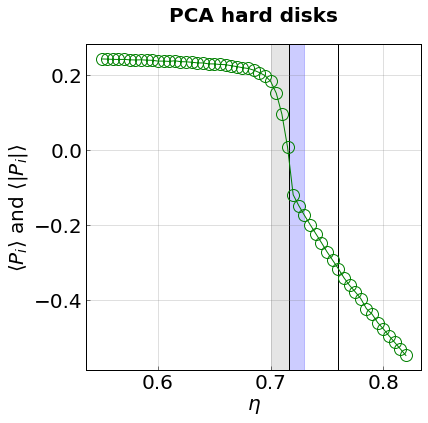

In [97]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

## Load in the saved model data

In [28]:
#load the pickled model
with open('./processed_data/incpca.pkl', 'rb') as handle:
    incpca = pickle.load(handle)

In [29]:
from numpy import mean, var, abs, arange, array
import pickle

#load the pickled model
raw_OPs_mean = []
raw_OPs_abs = []
raw_OPs_var = []
etas = arange(0.550, 0.820001, 0.005)
for eta in etas:
    print eta
    with open('./processed_data/raw_OPs_{:.4f}.pkl'.format(eta), 'rb') as handle:
        raw_OPs_split = pickle.load(handle)
        raw_OPs = []
        for split in raw_OPs_split:
            raw_OPs.extend(split)
        raw_OPs_mean.append(mean(raw_OPs, axis=0))
        raw_OPs_abs.append(mean(abs(raw_OPs), axis=0))
        raw_OPs_var.append(var(raw_OPs, axis=0))
raw_OPs_mean = array(raw_OPs_mean)   
raw_OPs_abs = array(raw_OPs_abs) 
raw_OPs_var = array(raw_OPs_var) 

0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81


IOError: [Errno 2] No such file or directory: './processed_data/raw_OPs_0.8100.pkl'

## The amount of variance explained by the components

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


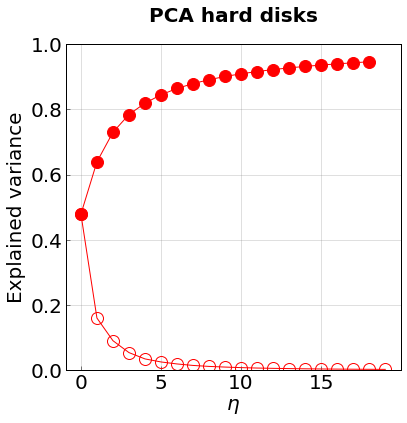

In [102]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca_ig.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
plt.plot([sum(incpca_ig.explained_variance_ratio_[:i]) for i in range(1,len(incpca_ig.explained_variance_ratio_))], marker='o', linewidth = 1.0, markersize=12, color = 'red')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylim(0.0,1.0)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


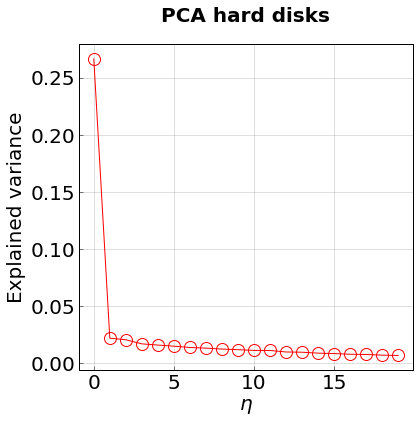

In [103]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
#plt.plot([sum(incpca.explained_variance_ratio_[:i]) for i in range(1,len(incpca_ig.explained_variance_ratio_))], marker='o', linewidth = 1.0, markersize=12, color = 'red')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.ylim(0.0,1.0)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

## Check out the components

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


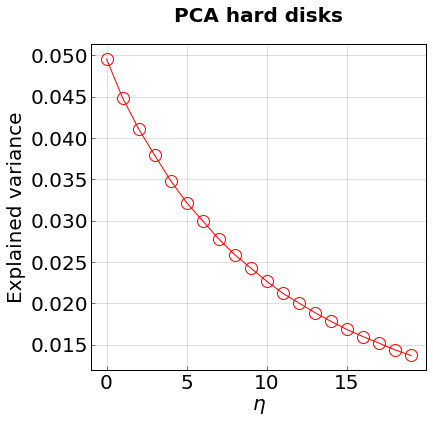

In [110]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
#plt.plot([sum(incpca.explained_variance_ratio_[:i]) for i in range(1,len(incpca_ig.explained_variance_ratio_))], marker='o', linewidth = 1.0, markersize=12, color = 'red')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.ylim(0.0,1.0)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [16]:
from numpy import array

In [17]:
raw_OPs_abs = array(raw_OPs_abs)  

In [43]:
#load the pickled model
with open('./processed_data/incpca.pkl', 'rb') as handle:
    incpca = pickle.load(handle)

In [24]:
from numpy import mean, var, abs, arange, array
import pickle

#load the pickled model
raw_OPs_mean = []
raw_OPs_abs = []
raw_OPs_var = []
etas = arange(0.550, 0.820001, 0.005)
for eta in etas:
    print eta
    with open('./processed_data/raw_OPs_{:.4f}.pkl'.format(eta), 'rb') as handle:
        raw_OPs_split = pickle.load(handle)
        raw_OPs = []
        for split in raw_OPs_split:
            raw_OPs.extend(split)
        raw_OPs_mean.append(mean(raw_OPs, axis=0))
        raw_OPs_abs.append(mean(abs(raw_OPs), axis=0))
        raw_OPs_var.append(var(raw_OPs, axis=0))
raw_OPs_mean = array(raw_OPs_mean)   
raw_OPs_abs = array(raw_OPs_abs) 
raw_OPs_var = array(raw_OPs_var) 

0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81


IOError: [Errno 2] No such file or directory: './processed_data/raw_OPs_0.8100.pkl'

In [41]:
raw_OPs_mean = array(raw_OPs_mean)   
raw_OPs_abs = array(raw_OPs_abs) 
raw_OPs_var = array(raw_OPs_var) 

NameError: name 'raw_OPs_mean' is not defined

In [85]:
etas = arange(0.550, 0.805001, 0.005)

NameError: name 'raw_OPs_mean' is not defined

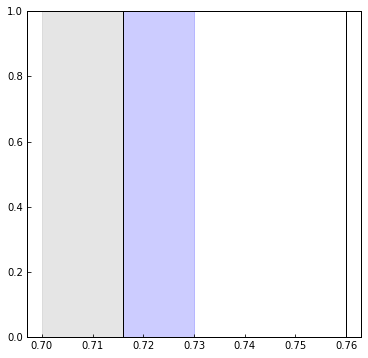

In [40]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(1,2): #12,13
    p_data = raw_OPs_mean[:,i]
    plt.plot(etas, -(p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = raw_OPs_var[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0.60, 0.81)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [55]:
etas = arange(0.550, 0.82001, 0.005)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


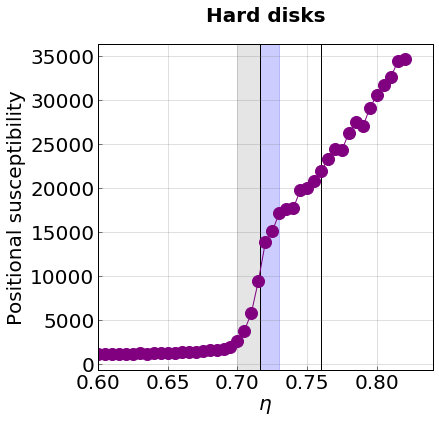

In [57]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(etas, Xs, marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Positional susceptibility', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Hard disks', y=1.05, fontdict = title_font)

plt.show()

In [17]:
#comps_ig = incpca.components_

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


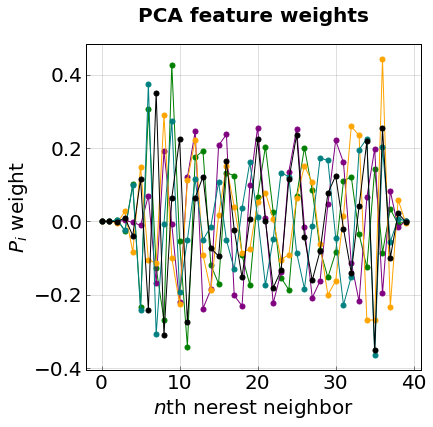

In [121]:
#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,5):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])
    #p_data = comps_ig[i]
    #plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 3.0, markersize=0, color = colors[i])
    #p_data = incpca.components_[i] - comps_ig[i]
    #plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 3.0, markersize=0, color = colors[i])
#plt.plot(etas, num_defects, marker='o', linewidth = 2.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,3000)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [41]:
import gsd.hoomd
from numpy import mean, array

def ColorParticlesPCA(filename_gsd, filename_xyz, pca):
    frames = []
    traj = gsd.hoomd.open(name=filename, mode='rb')
    
    #static quantities
    box = traj[0].configuration.box
    D = traj[0].configuration.dimensions
    
    #loop over the configurations and stor in new format
    for snap in traj:
        #dynamic quantities
        diameters = snap.particles.diameter
        coords = snap.particles.position
        
        #check for a square box
        if (max(box[0:D]) - min(box[0:D]))/mean(box[0:D]) > 0.000000000001:
            raise Exception('Not a rectangle or square!!!')
            
        L = box[0]
        
        #get the particle types
        possible_types = snap.particles.types
        types = array([possible_types[type_id] for type_id in snap.particles.typeid])
        
        #create our new data structure
        frames.append({'coords': (coords[:,0:D]+L/2.0), 'diameters': diameters, 'types': types, 'L': L, 'D': D})
        

In [381]:
frames = ReadGSD('../hoomd_disks/trajectories_4000p_longer/trajectory_0.1000.gsd')

In [54]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_2.1800.gsd', randomize = False)

In [34]:
pc = 0
xyz_file_stream = open('op_labeled/feature_labeled_particles_2.1800_P{}.xyz'.format(pc), 'w')
for frame in frames[0:40]:
    coords = frame['coords']
    N = len(coords)
    L = frame['L']
    types = frame['types']
    
    #create header
    xyz_file_stream.write('{}\n'.format(N))
    xyz_file_stream.write(' L={}\n'.format(L))
    features = FrameToFeatures(frame, N_nn, ['distance'], particle_inc=1, nn_inc=nn_inc)
    
    #transform the data to features
    ops = (incpca.transform(features)[:,pc])
    #ops = types
    #print len(ops)
    
    #joint data
    coords_ops_types = zip(coords, ops, types)
    for coord, op, type_ in coords_ops_types:
        xyz_file_stream.write('  {}    {}    {}    0.0    {}\n'.format(type_, coord[0], coord[1], op))
xyz_file_stream.close()
                                 

In [56]:
frames[0]

{'D': 2, 'L': 38.414631, 'coords': array([[ 11.06319141,  37.75015259],
        [  8.64294338,   4.37904453],
        [ 38.39389038,   1.4232254 ],
        ..., 
        [ 16.68315125,  22.83090782],
        [ 23.82643127,   7.47303104],
        [ 11.08653927,   9.76377487]], dtype=float32), 'diameters': array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), 'types': array([u'A', u'A', u'A', ..., u'B', u'B', u'B'],
       dtype='<U1')}

In [26]:
incpca_small = IncrementalPCA(n_components=16, whiten=True)

frames = None
features = None
split_features = None

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, N_nn=N_nn, method='distance', step=step)
            incpca_small.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.55

1
2
3
4
5
6
7
8
eta=0.555

1
2
3
4
5
6
7
8
eta=0.56

1
2
3
4
5
6
7
8
eta=0.565

1
2
3
4
5
6
7
8
eta=0.57

1
2
3
4
5
6
7
8
eta=0.575

1
2
3
4
5
6
7
8
eta=0.58

1
2
3
4
5
6
7
8
eta=0.585

1
2
3
4
5
6
7
8
eta=0.59

1
2
3
4
5
6
7
8
eta=0.595

1
2
3
4
5
6
7
8
eta=0.6

1
2
3
4
5
6
7
8
eta=0.605

1
2
3
4
5
6
7
8
eta=0.61

1
2
3
4
5
6
7
8
eta=0.615

1
2
3
4
5
6
7
8
eta=0.62

1
2
3
4
5
6
7
8
eta=0.625

1
2
3
4
5
6
7
8
eta=0.63

1
2
3
4
5
6
7
8
eta=0.635

1
2
3
4
5
6
7
8
eta=0.64

1
2
3
4
5
6
7
8
eta=0.645

1
2
3
4
5
6
7
8
eta=0.65

1
2
3
4
5
6
7
8
eta=0.655

1
2
3
4
5
6
7
8
eta=0.66

1
2
3
4
5
6
7
8
eta=0.665

1
2
3
4
5
6
7
8
eta=0.67

1
2
3
4
5
6
7
8
eta=0.675

1
2
3
4
5
6
7
8
eta=0.68

1
2
3
4
5
6
7
8
eta=0.685

1
2
3
4
5
6
7
8
eta=0.69

1
2
3
4
5
6
7
8
eta=0.695

1
2
3
4
5
6
7
8
eta=0.7

1
2
3
4
5
6
7
8
eta=0.705

1
2
3
4
5
6
7
8
eta=0.71

1
2
3
4
5
6
7
8
eta=0.715

1
2
3
4
5
6
7
8
eta=0.72

1
2
3
4
5
6
7
8
eta=0.725

1
2
3
4
5
6
7
8
eta=0.73

1
2
3
4
5
6
7
8
eta=0.735

1
2
3
4
5
6

In [27]:
OPs_small = []
frames = None
features = None
raw_OPs_small = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, N_nn=N_nn, method='distance', step=step)
            transformed_features_partial = incpca_small.transform(features_partial)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs_small.append(op)
        raw_OPs_small.append(raw_OPs_single)
    
OPs_small = array(OPs_small)        

eta=0.55

1
2
3
4
5
6
7
8
eta=0.555

1
2
3
4
5
6
7
8
eta=0.56

1
2
3
4
5
6
7
8
eta=0.565

1
2
3
4
5
6
7
8
eta=0.57

1
2
3
4
5
6
7
8
eta=0.575

1
2
3
4
5
6
7
8
eta=0.58

1
2
3
4
5
6
7
8
eta=0.585

1
2
3
4
5
6
7
8
eta=0.59

1
2
3
4
5
6
7
8
eta=0.595

1
2
3
4
5
6
7
8
eta=0.6

1
2
3
4
5
6
7
8
eta=0.605

1
2
3
4
5
6
7
8
eta=0.61

1
2
3
4
5
6
7
8
eta=0.615

1
2
3
4
5
6
7
8
eta=0.62

1
2
3
4
5
6
7
8
eta=0.625

1
2
3
4
5
6
7
8
eta=0.63

1
2
3
4
5
6
7
8
eta=0.635

1
2
3
4
5
6
7
8
eta=0.64

1
2
3
4
5
6
7
8
eta=0.645

1
2
3
4
5
6
7
8
eta=0.65

1
2
3
4
5
6
7
8
eta=0.655

1
2
3
4
5
6
7
8
eta=0.66

1
2
3
4
5
6
7
8
eta=0.665

1
2
3
4
5
6
7
8
eta=0.67

1
2
3
4
5
6
7
8
eta=0.675

1
2
3
4
5
6
7
8
eta=0.68

1
2
3
4
5
6
7
8
eta=0.685

1
2
3
4
5
6
7
8
eta=0.69

1
2
3
4
5
6
7
8
eta=0.695

1
2
3
4
5
6
7
8
eta=0.7

1
2
3
4
5
6
7
8
eta=0.705

1
2
3
4
5
6
7
8
eta=0.71

1
2
3
4
5
6
7
8
eta=0.715

1
2
3
4
5
6
7
8
eta=0.72

1
2
3
4
5
6
7
8
eta=0.725

1
2
3
4
5
6
7
8
eta=0.73

1
2
3
4
5
6
7
8
eta=0.735

1
2
3
4
5
6

In [36]:
from numpy import std, abs, power

OPs_small_std = []
OPs_small_abs = []
for single_eta in raw_OPs_small:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
        
    OPs_small_std.append(std(split, axis=0))
    OPs_small_abs.append(mean(abs(split), axis=0))
    
OPs_small_std = array(OPs_small_std)
OPs_small_abs = array(OPs_small_abs)

NameError: name 'OPs_small_abs' is not defined

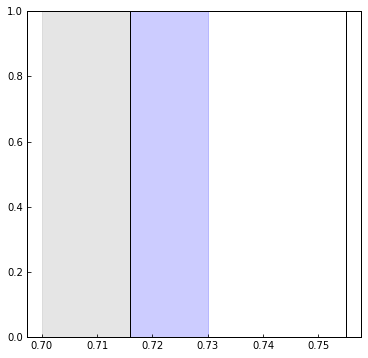

In [292]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.755, 0.755001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,4): #16,17
    #p_data = OPs_small[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_small_abs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(0.01,0.6)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [257]:
40*40

1600

## Testing WR mixture

In [1]:
import hoomd
import hoomd.hpmc

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
hoomd.context.initialize("--mode=cpu")

HOOMD-blue v2.1.7 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 05/11/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU


In [3]:
from numpy import pi, arange

In [4]:
d = 1.0
#etas = arange(0.65, 0.75, 0.002)
eta_init = 0.3
a = (((pi*d**2.0)/4.0)/eta_init)**(1.0/2.0)
n = 64

In [5]:
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=a), n=n)

notice(2): Group "all" created containing 4096 particles


In [6]:
mc = hoomd.hpmc.integrate.sphere(d=0.2, seed=1)
mc.shape_param.set('A', diameter=1.0)

In [7]:
system.particles.types.add('B')
for i in range(n*n/2, n*n):
    system.particles[i].type = 'B'

In [8]:
mc.shape_param.set('A', diameter=1.0)
mc.shape_param.set('B', diameter=1.0)
mc.overlap_checks.set('A', 'A', enable=False)
mc.overlap_checks.set('A', 'B', enable=True)
mc.overlap_checks.set('B', 'B', enable=False)

In [49]:
len(arange(0.48, 0.75001, 0.005))

55

In [11]:
hoomd.run(1000)

** starting run **
Time 00:00:41 | Step 1000 / 1000 | TPS 222.192 | ETA 00:00:00
Average TPS: 222.071
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.996867
notice(2): Trial moves per second:        3.63535e+06
notice(2): Overlap checks per second:     6.50141e+07
notice(2): Overlap checks per trial move: 17.8839
notice(2): Number of overlap errors:      0
** run complete **


In [9]:
def Compress(eta_tgt, scale=0.9):
    #get current state
    snap = system.take_snapshot()
    N = len(snap.particles.diameter)
    Vp = sum(pi*(snap.particles.diameter**2.0)/4.0)
    Vb = system.box.get_volume()
    eta = Vp/Vb
    eta_init = eta
    
    print '\nStarting from eta={}\n'.format(eta)
    
    #calculate new quantities
    Vb_tgt = Vp/eta_tgt
    
    #box compression loop
    while Vb > Vb_tgt:
        Vb = max(Vb*scale, Vb_tgt)
        eta = Vp/Vb
        new_box = system.box.set_volume(Vb)
        hoomd.update.box_resize(Lx=new_box.Lx, Ly=new_box.Ly, Lz=new_box.Lz, period=None)
        overlaps = mc.count_overlaps()
        
        #run until all overlaps are removed
        while overlaps > 0:
            hoomd.run(100, quiet=True)
            overlaps = mc.count_overlaps()
            
        print "Compressed to eta={}\n".format(eta)

In [12]:
Compress(0.8)


Starting from eta=0.333333342609

Compressed to eta=0.370370380677

Compressed to eta=0.411522645197

Compressed to eta=0.457247383552

Compressed to eta=0.508052648391

Compressed to eta=0.564502942656

Compressed to eta=0.62722549184

Compressed to eta=0.696917213156

Compressed to eta=0.774352459062

Compressed to eta=0.8



In [13]:
eta=0.80

hoomd.run(10000)
    
#set up the file writer and run the production version
d = hoomd.dump.gsd("./trajectories/trajectory_{:.4f}.gsd".format(eta), period=1000, group=hoomd.group.all(), overwrite=True)
hoomd.run(10000)
    
#diable old file writer
d.disable()

** starting run **
Time 00:01:10 | Step 3805 / 11900 | TPS 190.42 | ETA 00:00:42
Time 00:01:20 | Step 5694 / 11900 | TPS 188.836 | ETA 00:00:32
Time 00:01:30 | Step 7574 / 11900 | TPS 187.922 | ETA 00:00:23
Time 00:01:40 | Step 9445 / 11900 | TPS 187.018 | ETA 00:00:13
Time 00:01:50 | Step 11308 / 11900 | TPS 186.263 | ETA 00:00:03
Time 00:01:54 | Step 11900 / 11900 | TPS 185.272 | ETA 00:00:00
Average TPS: 187.915
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.988187
notice(2): Trial moves per second:        3.07858e+06
notice(2): Overlap checks per second:     7.58691e+07
notice(2): Overlap checks per trial move: 24.6442
notice(2): Number of overlap errors:      0
** run complete **
** starting run **
Time 00:02:04 | Step 13754 / 21900 | TPS 185.343 | ETA 00:00:43
Time 00:02:14 | Step 15603 / 21900 | TPS 184.845 | ETA 00:00:34
Time 00:02:24 | Step 17446 / 21900 | TPS 184.278 | ETA 00:00:24
Time 00:02:34 | Step 19280 / 21900 | TPS 183.358 | ETA 00:00:14

In [132]:
power(-2.0,3.1)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


nan

In [ ]:
for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    plt.plot(merged_data[:,0])

In [18]:
len(arange(0.60, 0.85001, 0.005))


51

In [88]:
from scipy.special import j0
from numpy import histogram, pi, power, rint
from numpy.linalg import norm
from numpy import trapz

#function for calculating the rdf
def RDF2D(frames, dr):
    M = len(frames)
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float((N-1))/power(L, 2)
    r_edg = arange(0.0, L/2.0, dr)
    r = (r_edg[:-1] + r_edg[1:])/2.0
    hist = 0.0*r
    
    #loop over the frames
    for frame in frames:
        coords = frame['coords']

        #loop over each particle
        for coord in coords:
            #nearest neighbor coordinate wrapping
            Rpj = coord - coords
            Rpj = Rpj - rint(Rpj/L)*L
            Rpj = norm(Rpj, axis=1)
            
            #calculate the histogram
            hist = hist + histogram(Rpj, bins=r_edg)[0]
    
    #normalize out the number of frames and 
    hist = hist/float(M*(N-1))
    gr = hist/((2.0*pi*r*dr)*rho)
    
    return r, gr

#function for calculating the integral of h(r)
def PositionalSuceptibility2D(frames, dr, k):
    N = float(len(frames[0]['coords']))
    L = frames[0]['L']
    rho = float(N)/power(L, 2)
    
    d = float(L)/rint(L)
    k = 2.0*pi/d
    
    #compute the rdfs and calculate S(k0)
    r, gr = RDF2D(frames, dr)
    #Sk0 = 1.0 + 2.0*pi*rho*trapz(r*(gr-1.0)*j0(k*r))
    Sk0 = 1.0 + 2.0*pi*rho*trapz(r*abs(gr-1.0))
    
    return (Sk0, r, gr)

In [400]:
from scipy.special import j0
from numpy import sin

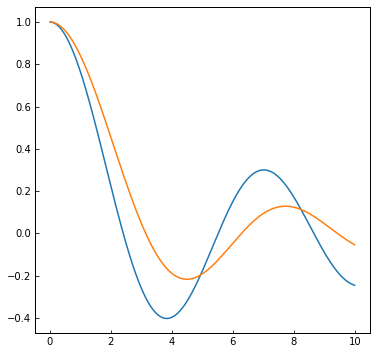

In [401]:
x = arange(0.01,10,0.01)
plt.plot(x, j0(x))
plt.plot(x, sin(x)/x)


In [426]:
x, r, gr = PositionalSuceptibility2D(frames[0::100], 0.025, 2.0*pi)

(0, 6)

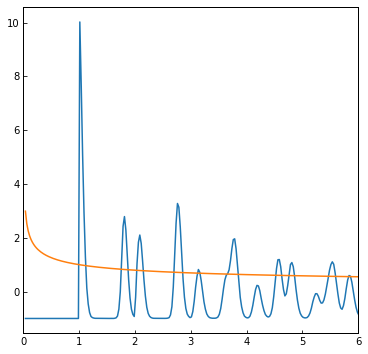

In [431]:
plt.plot(r[1:], (gr[1:]-1.0))
plt.plot(r[1:], 1/power(r[1:], 1.0/3.0))
plt.xlim(0,6)
#plt.ylim(0.001,10.0)
#plt.xscale('log')
#plt.yscale('log')

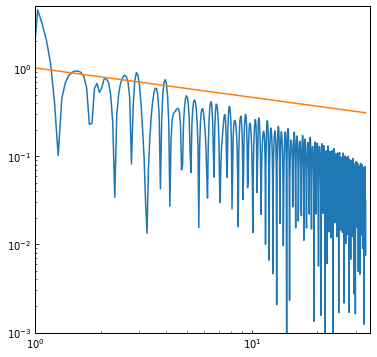

In [317]:
plt.plot(r[1:], abs(gr[1:]-1.0))
plt.plot(r[1:], 1/power(r[1:], 1.0/3.0))
plt.xlim(1,35)
plt.ylim(0.001,5.0)
plt.xscale('log')
plt.yscale('log')

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


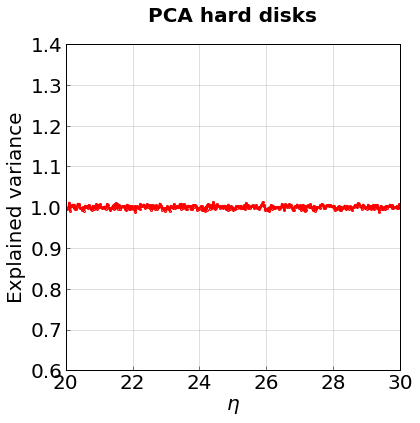

In [418]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

for r_gr in r_grs:
    plt.plot(r_grs[0][0], r_grs[0][1], marker='o', linewidth = 2.0, markersize=2, color = 'red', markerfacecolor='None')
    
#plt.plot([sum(incpca.explained_variance_ratio_[:i]) for i in range(1,len(incpca.explained_variance_ratio_))], marker='o', linewidth = 1.0, markersize=12, color = 'red')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlim(20,30)
plt.ylim(0.6,1.4)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [262]:
from numpy import trapz

In [266]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*(gr-1.0), r)

1062.9743662982394

In [277]:
rho = float(len(frames[0]['coords']))/frames[0]['L']
trapz(2.0*pi*rho*r*(gr-1.0), r)

510.23707895340073

In [49]:
r_grs = []
Xs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        X, r, gr = PositionalSuceptibility2D(frames[0::200], 0.025, k=2.0*pi/1.0)
        Xs.append(X)
        r_grs.append([r, gr])

eta=0.55

eta=0.555

eta=0.56

eta=0.565

eta=0.57

eta=0.575

eta=0.58

eta=0.585

eta=0.59

eta=0.595

eta=0.6

eta=0.605

eta=0.61

eta=0.615

eta=0.62

eta=0.625

eta=0.63

eta=0.635

eta=0.64

eta=0.645

eta=0.65

eta=0.655

eta=0.66

eta=0.665

eta=0.67

eta=0.675

eta=0.68

eta=0.685

eta=0.69

eta=0.695

eta=0.7

eta=0.705

eta=0.71

eta=0.715

eta=0.72

eta=0.725

eta=0.73

eta=0.735

eta=0.74

eta=0.745

eta=0.75

eta=0.755

eta=0.76

eta=0.765

eta=0.77

eta=0.775

eta=0.78

eta=0.785

eta=0.79

eta=0.795

eta=0.8

eta=0.805

eta=0.81

eta=0.815

eta=0.82



ValueError: x and y must have same first dimension, but have shapes (52,) and (55,)

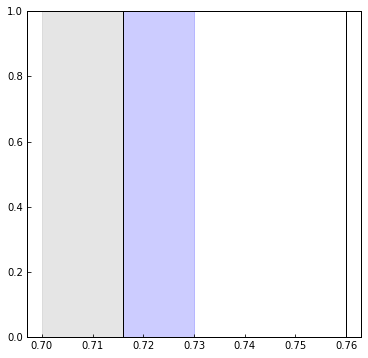

In [54]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(etas, Xs, marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Positional susceptibility', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

In [22]:
norm([[1,2,3],[2,2,2]], axis=1)

array([ 3.74165739,  3.46410162])

In [26]:
arange(0.0, 23./2.0, 0.02)

array([  0.  ,   0.02,   0.04,   0.06,   0.08,   0.1 ,   0.12,   0.14,
         0.16,   0.18,   0.2 ,   0.22,   0.24,   0.26,   0.28,   0.3 ,
         0.32,   0.34,   0.36,   0.38,   0.4 ,   0.42,   0.44,   0.46,
         0.48,   0.5 ,   0.52,   0.54,   0.56,   0.58,   0.6 ,   0.62,
         0.64,   0.66,   0.68,   0.7 ,   0.72,   0.74,   0.76,   0.78,
         0.8 ,   0.82,   0.84,   0.86,   0.88,   0.9 ,   0.92,   0.94,
         0.96,   0.98,   1.  ,   1.02,   1.04,   1.06,   1.08,   1.1 ,
         1.12,   1.14,   1.16,   1.18,   1.2 ,   1.22,   1.24,   1.26,
         1.28,   1.3 ,   1.32,   1.34,   1.36,   1.38,   1.4 ,   1.42,
         1.44,   1.46,   1.48,   1.5 ,   1.52,   1.54,   1.56,   1.58,
         1.6 ,   1.62,   1.64,   1.66,   1.68,   1.7 ,   1.72,   1.74,
         1.76,   1.78,   1.8 ,   1.82,   1.84,   1.86,   1.88,   1.9 ,
         1.92,   1.94,   1.96,   1.98,   2.  ,   2.02,   2.04,   2.06,
         2.08,   2.1 ,   2.12,   2.14,   2.16,   2.18,   2.2 ,   2.22,
      

In [27]:
11.48*2

22.96

In [216]:
from numpy import save, load

In [ ]:
numpy.save(file, arr, allow_pickle=True, fix_imports=True)[source]

In [220]:
file = open(".testfile.txt","r") 

In [214]:
save(file, [[1,2],[3,43],[9.0,7]])

In [222]:
file.close()

In [223]:
a = array([[1,2,3],[4,5,6]])

In [224]:
with open('./data.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [226]:
with open('./processed_data/raw_OPs.pickle', 'rb') as handle:
    raw_OPs = pickle.load(handle)

In [87]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_1.5000.gsd', shuffle_data=True)

In [103]:
r, gr = RDF2D(frames[0::10], 0.15)

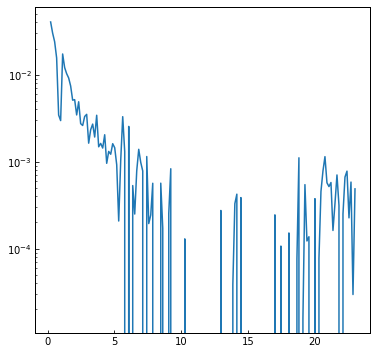

In [105]:
plt.plot(r[1:], gr[1:]-1)
#plt.plot(r, 1/power(r, 1.0/3.0))
#plt.xlim(1,35)
#plt.ylim(0.001,5.0)
#plt.xscale('log')
plt.yscale('log')

In [106]:
frames[0]

{'D': 2, 'L': 46.310482, 'coords': array([[ 17.61962891,  20.17847633],
        [ 17.09300041,  17.70657349],
        [  5.15569687,   3.58562469],
        ..., 
        [ 30.17601585,   2.96033478],
        [ 32.05548096,   2.4064827 ],
        [ 39.42152786,  18.0430069 ]], dtype=float32), 'diameters': array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32), 'types': array([u'A', u'A', u'A', ..., u'B', u'B', u'B'],
       dtype='<U1')}

In [111]:
frames[0]['types']

NameError: name 'unique' is not defined

In [155]:
from numpy import unique, place, transpose
from copy import deepcopy

In [144]:
particle_types = deepcopy(frames[0]['types'])

In [145]:
unique(particle_types)

array([u'A', u'B'],
      dtype='<U1')

In [146]:
particle_types == 'A'

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [147]:
#place(particle_types, particle_types=='A', [[1,0]])

In [148]:
particle_types

array([u'A', u'A', u'A', ..., u'B', u'B', u'B'],
      dtype='<U1')

In [150]:
particle_types[particle_types == 'A'] = (1,0)

ValueError: NumPy boolean array indexing assignment cannot assign 2 input values to the 2048 output values where the mask is true

In [143]:
particle_types

array([u'5', u'5', u'5', ..., u'B', u'B', u'B'],
      dtype='<U1')

In [151]:
from sklearn import preprocessing

In [163]:
lb = preprocessing.LabelBinarizer()
lb.fit(['A','B', 'C'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [166]:
lb.transform(particle_types).flatten()

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
lb.transform

In [305]:
frames = ReadGSD('../hoomd_disks/trajectories_ww_4000p/trajectory_1.0000.gsd', shuffle_data=True)

In [306]:
features = FrameToFeatures(frames[0], 50, ['composition'], 10, 1)

In [307]:
features[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1])

In [248]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    frame_features = []
    combined_data = zip(coords, p_types)
    for particle, p_type in combined_data[0::particle_inc]:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #generate statistics for various nearest neighbors
        sorter = Rpj.argsort()
        Rpj = Rpj[sorter[::1]]
        
        #for composition calculations (the identity of the tagged particle is automatically included via the 0th entry)
        if 'composition' in method:
            p_types_one_hot = p_types[sorter[::1]]
            lb = preprocessing.LabelBinarizer()
            lb.fit(unique(p_types_one_hot))
            p_types_one_hot = lb.transform(p_types_one_hot).flatten()
        
        #chosen axis for measuring angles based on nearest neighbor
        if 'angular' in method:
            #sort the particle-particle vectors according to distance
            Rpj_v = Rpj_v[sorter[::1]]
            
            #normalize all of the vectors
            Rpj_v = Rpj_v/maximum(norm(Rpj_v, axis=1), 1.0e-10)[:,None]
            
            #find the unit x and y axis to base all angular details on using the 1st and 2nd nearest neighbors
            x_axis = Rpj_v[1] #this specifies the x direction to measure the angular elevation from
            y_axis = Rpj_v[2] - array([dot(Rpj_v[2], Rpj_v[1]), 0.0]) #this specifies the upper two quadrants
            y_axis = y_axis/norm(y_axis)
            
            #compute the raw angle between 0-pi that has unresolved upper and lower quadrants
            x_axis_T = transpose(x_axis)
            y_axis_T = transpose(y_axis)
            Tpj = arccos(minimum(maximum(dot(Rpj_v, x_axis_T), -0.9999999), 0.9999999))
            
            #determine if the vector points into the upper quadrant defined by the second nearest neighbor
            LQ = arccos(minimum(maximum(dot(Rpj_v, y_axis_T), -0.9999999), 0.9999999)) > pi/2.0
            
            #adjust the angle to upper or lower quadrants 
            Tpj[LQ] = 2.0*pi - Tpj[LQ]
        
        #possible feature options
        feature_batch = []
        if 'distance' in method:
            feature_batch.extend((Rpj[1:N_nn+1]/normalizing_distance)[0::nn_inc])
        if 'composition' in method:
            feature_batch.extend(p_types_one_hot[0:N_nn+1][0::nn_inc])
        if 'angular' in method:
            feature_batch.extend(append(cos(Tpj[2:N_nn+1])[0::nn_inc], 
                                        sin(Tpj[2:N_nn+1])[0::nn_inc], axis=0))
            
        frame_features.append(feature_batch)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeatures(frames, N_nn, method, particle_inc, nn_inc):
    #print filename
    features = []
    for frame in frames:        
        features_sp = FrameToFeatures(frame, N_nn, method, particle_inc, nn_inc)
        for feature in features_sp:
            features.append(feature)
    return features

### WR mixture

In [352]:
from copy import deepcopy
from numpy import power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array
from numpy.linalg import norm
from numpy.random import shuffle
from sklearn import preprocessing

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesComposition(frame, probe_particle_indicies):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    p_types = deepcopy(frame['types'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    diameters = frame['diameters']
    diameters_scaled = frame['diameters']/frame['diameters'][0]
    
    #reduce the coords down to only those we care about
    coords = coords[probe_particle_indicies]

    #build up the features considering only the probes
    frame_features = []
    for particle in coords:
        #nearest neighbor coordinate wrapping
        Rpj_v = particle - coords
        Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
        Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     
        
        #extend the feature vector stacking the particle side by side
        frame_features.extend(Rpj/normalizing_distance)

    return array(frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeaturesComposition(frames, probe_particle_indicies):
    features = []
    for frame in frames:        
        features.append(FrameToFeaturesComposition(frame, probe_particle_indicies))
    return features

In [418]:
len(arange(0,4096,1)[0::40])

103

In [483]:
#specify what data to read in and process
file_data = [(arange(0.100, 2.06001, 0.04), '../hoomd_disks/trajectories_ww_4000p')]
probe_particle_indicies = arange(0,4096,1)[0::40]
split=4

In [484]:
incpca = IncrementalPCA(n_components=16, whiten=True)

frames = None
features = None
split_features = None

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            incpca.partial_fit(features_partial)
            count = count + 1
            print count
        frames_split = None

eta=0.1

1
2
3
4
eta=0.14

1
2
3
4
eta=0.18

1
2
3
4
eta=0.22

1
2
3
4
eta=0.26

1
2
3
4
eta=0.3

1
2
3
4
eta=0.34

1
2
3
4
eta=0.38

1
2
3
4
eta=0.42

1
2
3
4
eta=0.46

1
2
3
4
eta=0.5

1
2
3
4
eta=0.54

1
2
3
4
eta=0.58

1
2
3
4
eta=0.62

1
2
3
4
eta=0.66

1
2
3
4
eta=0.7

1
2
3
4
eta=0.74

1
2
3
4
eta=0.78

1
2
3
4
eta=0.82

1
2
3
4
eta=0.86

1
2
3
4
eta=0.9

1
2
3
4
eta=0.94

1
2
3
4
eta=0.98

1
2
3
4
eta=1.02

1
2
3
4
eta=1.06

1
2
3
4
eta=1.1

1
2
3
4
eta=1.14

1
2
3
4
eta=1.18

1
2
3
4
eta=1.22

1
2
3
4
eta=1.26

1
2
3
4
eta=1.3

1
2
3
4
eta=1.34

1
2
3
4
eta=1.38

1
2
3
4
eta=1.42

1
2
3
4
eta=1.46

1
2
3
4
eta=1.5

1
2
3
4
eta=1.54

1
2
3
4
eta=1.58

1
2
3
4
eta=1.62

1
2
3
4
eta=1.66

1
2
3
4
eta=1.7

1
2
3
4
eta=1.74

1
2
3
4
eta=1.78

1
2
3
4
eta=1.82

1
2
3
4
eta=1.86

1
2
3
4
eta=1.9

1
2
3
4
eta=1.94

1
2
3
4
eta=1.98

1
2
3
4
eta=2.02

1
2
3
4
eta=2.06

1
2
3
4


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


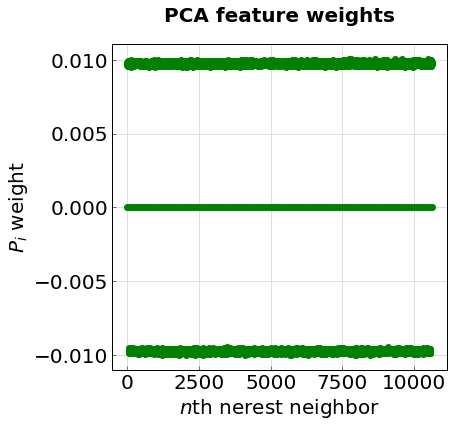

In [498]:
#highlight the transition region if found
#plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
#plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

#plt.axvspan(0.716, 0.716001, alpha=1, color='black')
#plt.axvspan(0.781, 0.781001, alpha=1, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 0.0, markersize=6, color = colors[i])
    #p_data = OPs_non_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 2.0, markersize=10, color = colors[i])
#plt.plot(etas, num_defects, marker='o', linewidth = 2.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0,103)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

In [486]:
OPs = []
frames = None
features = None
raw_OPs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeaturesComposition(frames_partial, probe_particle_indicies=probe_particle_indicies)
            transformed_features_partial = incpca.transform(features_partial)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs.append(op)
        raw_OPs.append(raw_OPs_single)
    
OPs = array(OPs)        

eta=0.1

1
2
3
4
eta=0.14

1
2
3
4
eta=0.18

1
2
3
4
eta=0.22

1
2
3
4
eta=0.26

1
2
3
4
eta=0.3

1
2
3
4
eta=0.34

1
2
3
4
eta=0.38

1
2
3
4
eta=0.42

1
2
3
4
eta=0.46

1
2
3
4
eta=0.5

1
2
3
4
eta=0.54

1
2
3
4
eta=0.58

1
2
3
4
eta=0.62

1
2
3
4
eta=0.66

1
2
3
4
eta=0.7

1
2
3
4
eta=0.74

1
2
3
4
eta=0.78

1
2
3
4
eta=0.82

1
2
3
4
eta=0.86

1
2
3
4
eta=0.9

1
2
3
4
eta=0.94

1
2
3
4
eta=0.98

1
2
3
4
eta=1.02

1
2
3
4
eta=1.06

1
2
3
4
eta=1.1

1
2
3
4
eta=1.14

1
2
3
4
eta=1.18

1
2
3
4
eta=1.22

1
2
3
4
eta=1.26

1
2
3
4
eta=1.3

1
2
3
4
eta=1.34

1
2
3
4
eta=1.38

1
2
3
4
eta=1.42

1
2
3
4
eta=1.46

1
2
3
4
eta=1.5

1
2
3
4
eta=1.54

1
2
3
4
eta=1.58

1
2
3
4
eta=1.62

1
2
3
4
eta=1.66

1
2
3
4
eta=1.7

1
2
3
4
eta=1.74

1
2
3
4
eta=1.78

1
2
3
4
eta=1.82

1
2
3
4
eta=1.86

1
2
3
4
eta=1.9

1
2
3
4
eta=1.94

1
2
3
4
eta=1.98

1
2
3
4
eta=2.02

1
2
3
4
eta=2.06

1
2
3
4


In [487]:
from numpy import std, abs, power
from scipy.stats import moment

OPs = []
OPs_std = []
OPs_abs = []
OPs_third = []
for single_eta in raw_OPs:
    merged_data = []
    for split in single_eta:
        merged_data.extend(split)
    
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))
    OPs_third.append(moment(split, 4, axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)
OPs_third = array(OPs_third)

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


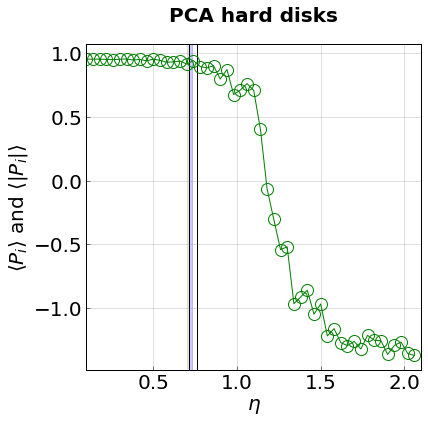

In [504]:
#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.730, alpha=0.2, color='blue')

plt.axvspan(0.716, 0.716001, alpha=1, color='black')
plt.axvspan(0.76, 0.76001, alpha=1, color='black')

#plt.axvspan(0.72, 0.72001, alpha=10, color='black')

#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_abs[:,i]
    #plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i])
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(0.10, 2.1)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


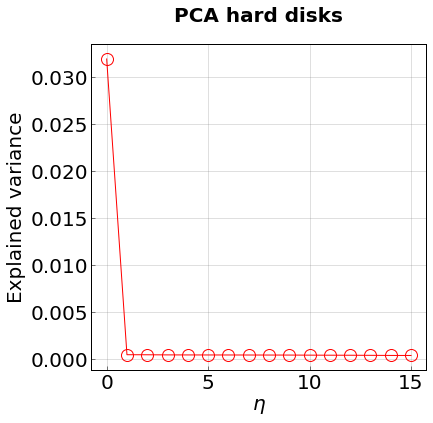

In [496]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth = 1.0, markersize=12, color = 'red', markerfacecolor='None')
#plt.plot([sum(incpca.explained_variance_ratio_[:i]) for i in range(1,len(incpca.explained_variance_ratio_))], marker='o', linewidth = 1.0, markersize=12, color = 'red')
    
#plt.plot(etas, num_defects, marker='o', linewidth = 1.0, markersize=10, color = 'black')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.ylim(0.0,0.8)
#plt.yscale('log')

plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA hard disks', y=1.05, fontdict = title_font)

plt.show()

### Old stuff

In [ ]:
OPs = []
frames = None
features = None
raw_OPs = []

for etas, file_base in file_data:
    for eta in etas:
        print 'eta={}\n'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        raw_OPs_single = []
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            transformed_features_partial = incpca.transform(features_partial - features_partial_ig_projection)
            means.append(mean(transformed_features_partial, axis=0))
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
            
        means = array(means)
        op = mean(means, axis=0)
        OPs.append(op)
        raw_OPs.append(raw_OPs_single)
    
OPs = array(OPs)        